In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import re

import math

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score


import scipy.stats as scs
import statsmodels.api as sm


%matplotlib inline

##### Read in the Data

In [2]:
raw_data = pd.read_csv('/Users/brandonmojica/Desktop/Galvanize/Capstones/Capstone_2/stockx_price_predict/data/StockX-Data-2019.csv')

##### Quick pass of the data to get an idea of what we are dealing with. 

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
Order Date      99956 non-null object
Brand           99956 non-null object
Sneaker Name    99956 non-null object
Sale Price      99956 non-null object
Retail Price    99956 non-null object
Release Date    99956 non-null object
Shoe Size       99956 non-null float64
Buyer Region    99956 non-null object
dtypes: float64(1), object(7)
memory usage: 6.1+ MB


In [4]:
raw_data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island


#### Data Cleaning Pt 1: Remove the dollar signs for columns sale price and retial price

In [5]:
#Create a copy of the data just for backup
stockx_data = raw_data.copy()

In [6]:
def remove_unwanted_chars(string):
    
    """
    Inputs: string
    
    Description: A function that removes the "$" and "," and converts the string into an integer

    Returns: int
    
    """
    string = string.strip('$')
    string = string.replace(',','')
    string = int(string)
    
    return string

In [7]:
#Use the function remove_unwanted_chars to remove $ and ,
stockx_data['Retail Price'] = stockx_data['Retail Price'].apply(remove_unwanted_chars)

In [8]:
stockx_data['Sale Price'] = stockx_data['Sale Price'].apply(remove_unwanted_chars)

In [9]:
stockx_data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2/11/17,11.0,Rhode Island


In [10]:
#covert the order date to a datetime type. 
stockx_data['Order Date'] = stockx_data['Order Date'].astype('datetime64[ns]') 

In [11]:
stockx_data['Release Date'] = stockx_data['Release Date'].astype('datetime64[ns]') 

In [12]:
stockx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
Order Date      99956 non-null datetime64[ns]
Brand           99956 non-null object
Sneaker Name    99956 non-null object
Sale Price      99956 non-null int64
Retail Price    99956 non-null int64
Release Date    99956 non-null datetime64[ns]
Shoe Size       99956 non-null float64
Buyer Region    99956 non-null object
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 6.1+ MB


In [13]:
stockx_data.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island


In [14]:
#convert the the order date into sperate cols 
stockx_data['Order year'] = stockx_data['Order Date'].dt.year 
stockx_data['Order month'] = stockx_data['Order Date'].dt.month 
stockx_data['Order day'] = stockx_data['Order Date'].dt.day

In [15]:
#convert the the release date into sperate cols 
stockx_data['Release year'] = stockx_data['Release Date'].dt.year 
stockx_data['Release month'] = stockx_data['Release Date'].dt.month 
stockx_data['Release day'] = stockx_data['Release Date'].dt.day

In [16]:
stockx_data.rename(columns={'Sneaker Name':'shoe'},inplace=True)

In [17]:
stockx_data.tail()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day
99951,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565,220,2018-12-26,8.0,Oregon,2019,2,13,2018,12,26
99952,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598,220,2018-12-26,8.5,California,2019,2,13,2018,12,26
99953,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605,220,2018-12-26,5.5,New York,2019,2,13,2018,12,26
99954,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650,220,2018-12-26,11.0,California,2019,2,13,2018,12,26
99955,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,640,220,2018-12-26,11.5,Texas,2019,2,13,2018,12,26


In [18]:
#How many unique types of shoes are there
len(stockx_data['shoe'].unique())

50

In [19]:
#How many unique types of shoes are there
stockx_data['Brand'].unique()

array([' Yeezy', 'Off-White'], dtype=object)

In [20]:
stockx_data['shoe'].unique()

array(['Adidas-Yeezy-Boost-350-Low-V2-Beluga',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Copper',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Green',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Red',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017',
       'Adidas-Yeezy-Boost-350-V2-Core-Black-White',
       'Adidas-Yeezy-Boost-350-V2-Cream-White',
       'Adidas-Yeezy-Boost-350-V2-Zebra',
       'Adidas-Yeezy-Boost-350-Low-Moonrock', 'Nike-Air-Max-90-Off-White',
       'Nike-Air-Presto-Off-White', 'Nike-Air-VaporMax-Off-White',
       'Air-Jordan-1-Retro-High-Off-White-Chicago',
       'Nike-Blazer-Mid-Off-White',
       'Adidas-Yeezy-Boost-350-Low-Pirate-Black-2016',
       'Adidas-Yeezy-Boost-350-Low-Oxford-Tan',
       'Adidas-Yeezy-Boost-350-Low-Turtledove',
       'Adidas-Yeezy-Boost-350-Low-Pirate-Black-2015',
       'Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow',
       'Nike-Air-Force-1-Low-Off-White', 'Nike-Air-Max-97-Off-White',
       'Nike-Air-Force-1-Low-Virgil

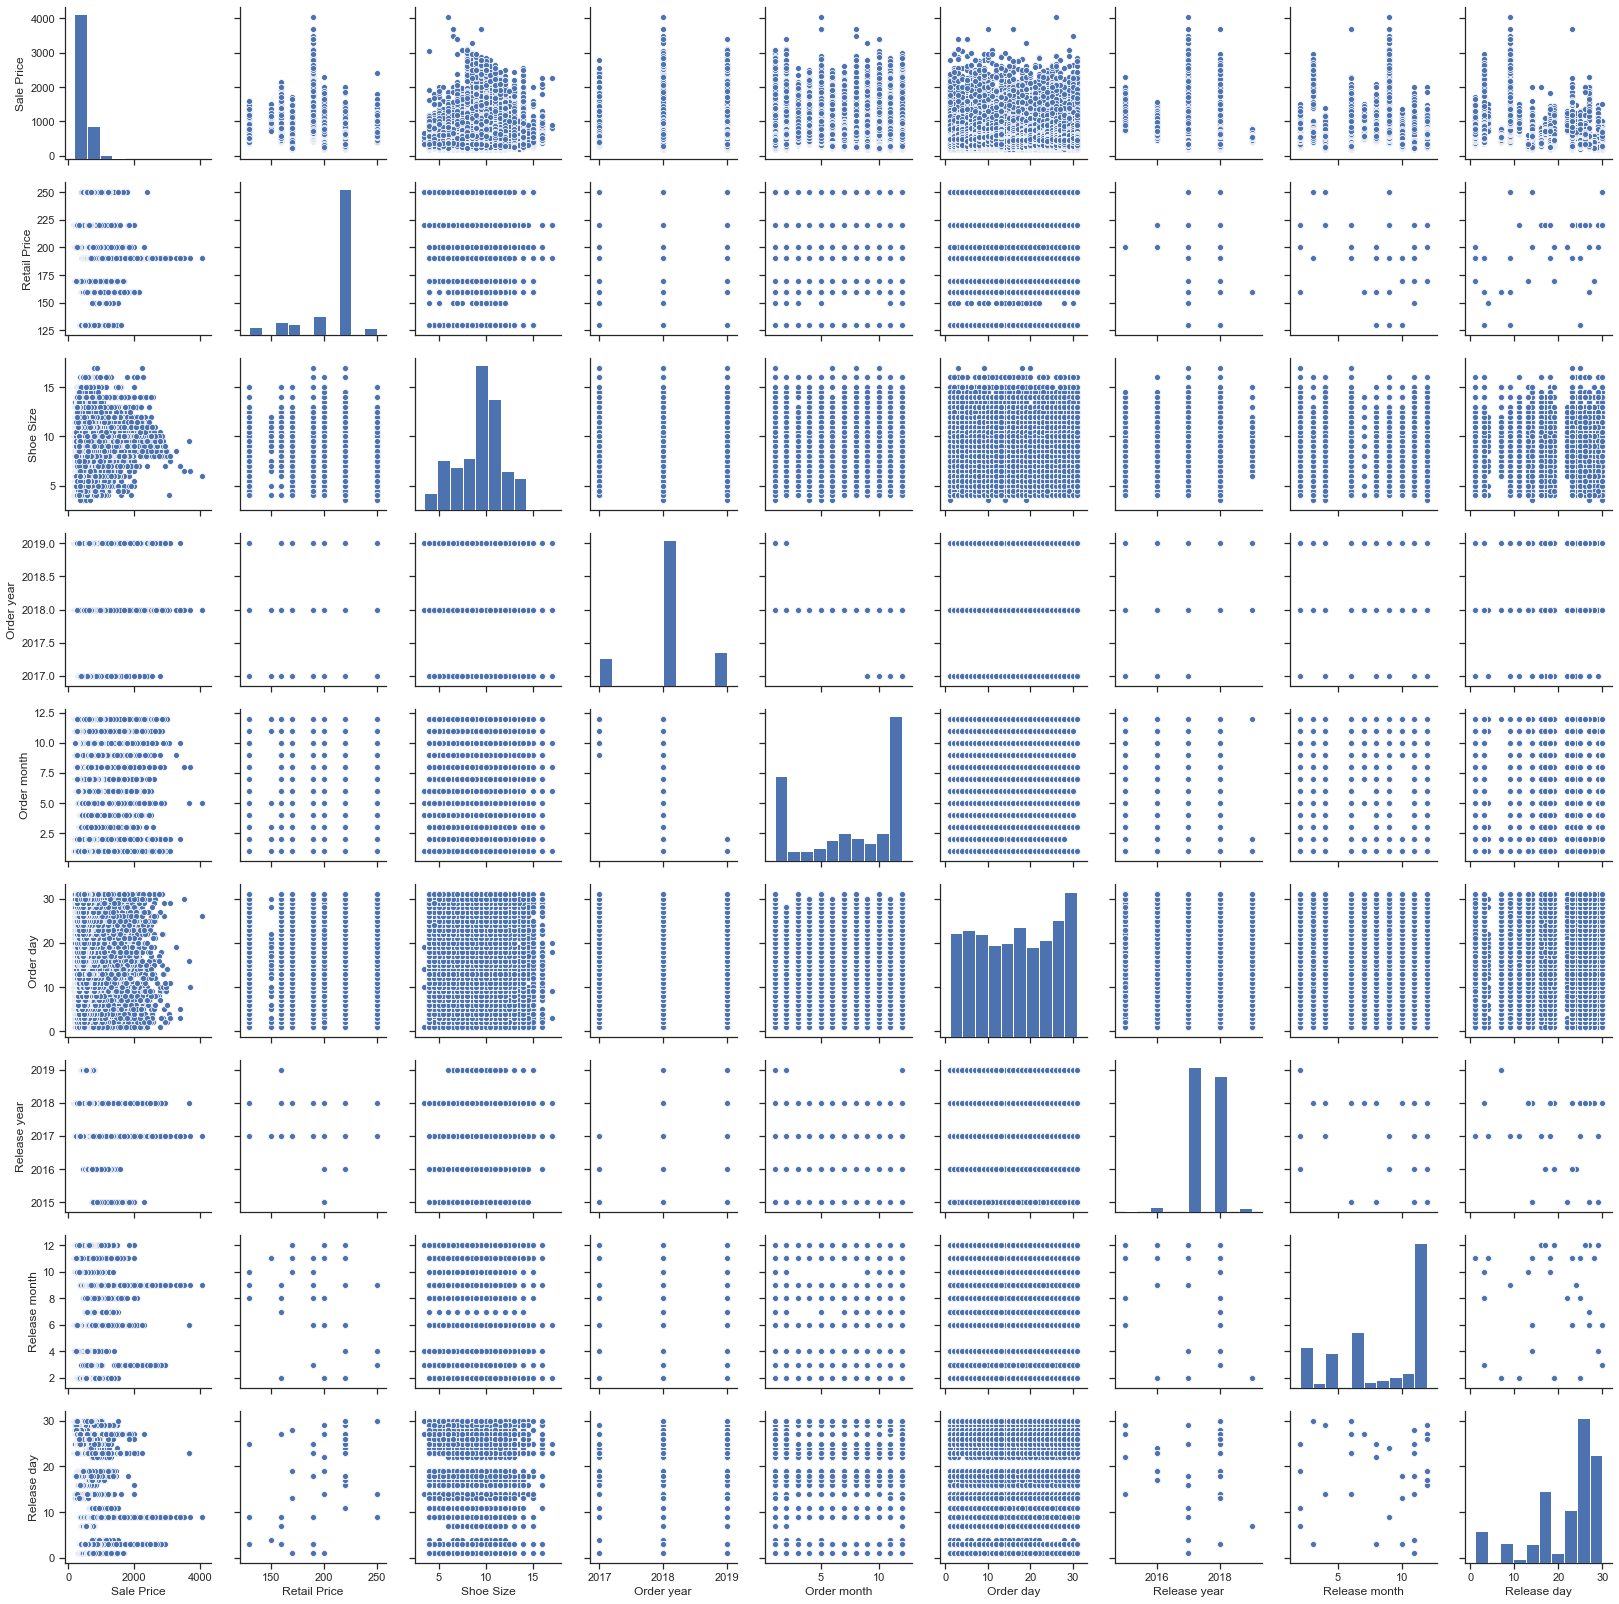

In [20]:
sns.set(style="ticks")
sns.pairplot(stockx_data)

In [21]:
stockx_data.groupby('Shoe Size')['Order Date'].count()

Shoe Size
3.5         4
4.0      2241
4.5      1304
5.0      3577
5.5      2621
6.0      4013
6.5      2219
7.0      3867
7.5      2664
8.0      5363
8.5      5300
9.0      9706
9.5      8685
10.0    11093
10.5     8784
11.0     9251
11.5     4502
12.0     7297
12.5      628
13.0     4602
13.5      147
14.0     1791
14.5       84
15.0      130
16.0       79
17.0        4
Name: Order Date, dtype: int64

In [22]:
states = stockx_data.groupby('Buyer Region')['Order Date'].count().sort_values(ascending=False)

In [23]:
states_counts_df = states.to_frame()

In [24]:
states_counts_df.reset_index(inplace=True)

In [25]:
states_counts_df.rename(columns={'Order Date':'counts','Buyer Region':'states'},inplace=True)

In [26]:
states_counts_df

,states,counts
0,California,19349
1,New York,16525
2,Oregon,7681
3,Florida,6376
4,Texas,5876
5,New Jersey,4720
6,Illinois,3782
7,Pennsylvania,3109
8,Massachusetts,2903
9,Michigan,2762


In [27]:
top_20_states = states_counts_df[0:21]

In [28]:
top_20_states

,states,counts
0,California,19349
1,New York,16525
2,Oregon,7681
3,Florida,6376
4,Texas,5876
5,New Jersey,4720
6,Illinois,3782
7,Pennsylvania,3109
8,Massachusetts,2903
9,Michigan,2762


[Text(0, 0, 'California'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Texas'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Virginia'),
 Text(0, 0, 'Ohio'),
 Text(0, 0, 'Maryland'),
 Text(0, 0, 'Washington'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Arizona'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'Delaware'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'Indiana'),
 Text(0, 0, 'Colorado')]

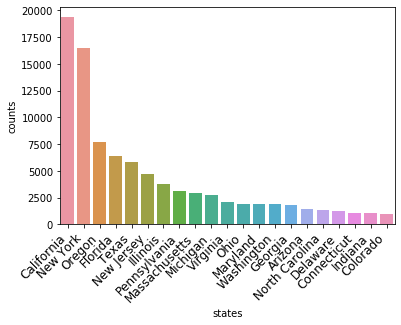

In [29]:
chart = sns.barplot(x='states', y= 'counts', data = top_20_states)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large')

In [30]:
top_10_states = states_counts_df[0:11]

[Text(0, 0, 'California'),
 Text(0, 0, 'New York'),
 Text(0, 0, 'Oregon'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Texas'),
 Text(0, 0, 'New Jersey'),
 Text(0, 0, 'Illinois'),
 Text(0, 0, 'Pennsylvania'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Virginia')]

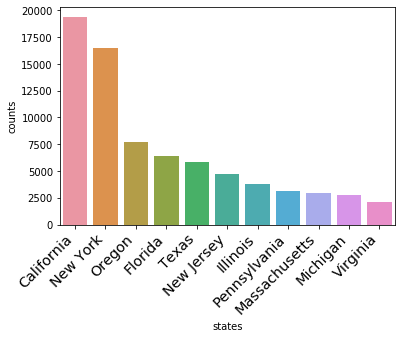

In [31]:
chart = sns.barplot(x='states', y= 'counts', data = top_10_states)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')

In [32]:
sneakers = stockx_data.groupby('shoe')['Order Date'].count().sort_values(ascending=False)

In [33]:
sneakers.to_frame()

,Order Date
shoe,
adidas-Yeezy-Boost-350-V2-Butter,11423
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,10395
Adidas-Yeezy-Boost-350-V2-Zebra,10110
Adidas-Yeezy-Boost-350-V2-Blue-Tint,9297
Adidas-Yeezy-Boost-350-V2-Cream-White,9097
Adidas-Yeezy-Boost-350-V2-Sesame,5553
adidas-Yeezy-Boost-350-V2-Static,4983
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow,4854
Air-Jordan-1-Retro-High-Off-White-University-Blue,4635


In [34]:
top_10_sneakers = sneakers[0:11]

In [35]:
top_10_df = top_10_sneakers.to_frame()

In [36]:
top_10_df.rename(columns={'Order Date':'counts'},inplace=True)

In [37]:
top_10_df

,counts
shoe,
adidas-Yeezy-Boost-350-V2-Butter,11423
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,10395
Adidas-Yeezy-Boost-350-V2-Zebra,10110
Adidas-Yeezy-Boost-350-V2-Blue-Tint,9297
Adidas-Yeezy-Boost-350-V2-Cream-White,9097
Adidas-Yeezy-Boost-350-V2-Sesame,5553
adidas-Yeezy-Boost-350-V2-Static,4983
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow,4854
Air-Jordan-1-Retro-High-Off-White-University-Blue,4635


In [38]:
top_10_df.reset_index(inplace=True)

[Text(0, 0, 'adidas-Yeezy-Boost-350-V2-Butter'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Beluga-2pt0'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Zebra'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Blue-Tint'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Cream-White'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Sesame'),
 Text(0, 0, 'adidas-Yeezy-Boost-350-V2-Static'),
 Text(0, 0, 'Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow'),
 Text(0, 0, 'Air-Jordan-1-Retro-High-Off-White-University-Blue'),
 Text(0, 0, 'adidas-Yeezy-Boost-350-V2-Static-Reflective'),
 Text(0, 0, 'Nike-Air-Presto-Off-White-Black-2018')]

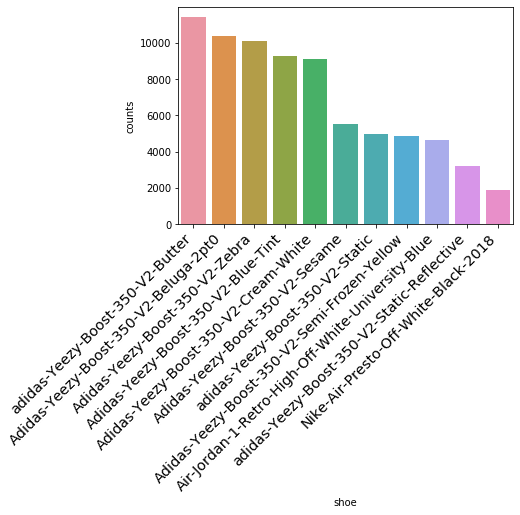

In [39]:
chart = sns.barplot(x='shoe', y= 'counts', data = top_10_df)

chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')

In [40]:
avg_sale_price = stockx_data.groupby('shoe').mean()

In [41]:
# Compute the avergae of the types of shoes and add it to the df
stockx_data['average_sale_price'] = stockx_data['Sale Price'].groupby(stockx_data['shoe']).transform('mean')

In [42]:
#compute the price premium for the shoe
stockx_data['shoe_premium'] = (stockx_data['average_sale_price'] - stockx_data['Retail Price'])/stockx_data['Retail Price']

In [43]:
#compute the price premium for the shoe
stockx_data['2017_annual_high'] = stockx_data['Sale Price'].groupby(stockx_data['']).transform('mean')

KeyError: ''

In [44]:
stockx_data['annual_high'] = stockx_data[stockx_data['Order year']==2017 ].groupby('shoe')['Sale Price'].transform('max')

In [498]:
stockx_data['annual_high'].where(stockx_data['Order year']==2018)

#stockx_data[stockx_data['Order year']==2018 ].groupby('shoe')['Sale Price'].transform('max')





0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
99951   NaN
99952   NaN
99953   NaN
99954   NaN
99955   NaN
Name: annual_high, Length: 99956, dtype: float64

In [45]:
stockx_data['Sale Price'].groupby(stockx_data['shoe']).max()

#stockx_data['average_sale_price'] = stockx_data['Sale Price'].groupby(stockx_data['shoe']).transform('mean')

shoe
Adidas-Yeezy-Boost-350-Low-Moonrock                  2000
Adidas-Yeezy-Boost-350-Low-Oxford-Tan                1470
Adidas-Yeezy-Boost-350-Low-Pirate-Black-2015         1300
Adidas-Yeezy-Boost-350-Low-Pirate-Black-2016         1455
Adidas-Yeezy-Boost-350-Low-Turtledove                2300
Adidas-Yeezy-Boost-350-Low-V2-Beluga                 1490
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0                 840
Adidas-Yeezy-Boost-350-V2-Blue-Tint                  2000
Adidas-Yeezy-Boost-350-V2-Core-Black-Copper          1095
Adidas-Yeezy-Boost-350-V2-Core-Black-Green            999
Adidas-Yeezy-Boost-350-V2-Core-Black-Red             1575
Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017        1515
Adidas-Yeezy-Boost-350-V2-Core-Black-White           1100
Adidas-Yeezy-Boost-350-V2-Cream-White                 773
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow         1825
Adidas-Yeezy-Boost-350-V2-Sesame                      545
Adidas-Yeezy-Boost-350-V2-Zebra                       899
Air-Jorda

In [46]:
(788.704819 - 220)/220

2.5850219045454548

In [47]:
2.585022 * 220

568.70484

In [110]:
stockx_data.head()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up,log_shoe_premium
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,788.704819,2.585022,1490.0,877,0.949734
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,656.631111,1.984687,1095.0,465,0.685461
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,622.801020,1.830914,920.0,470,0.604815
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,937.754967,3.262523,1200.0,855,1.182501
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,804.304438,2.655929,1160.0,608,0.976795


In [120]:
stockx_data['log_shoe_premium'] = np.log(stockx_data['shoe_premium'])

TypeError: cannot convert the series to <class 'float'>

In [112]:
scaler = StandardScaler()

In [116]:
scaler.fit(stockx_data['shoe_premium'].reshape(-1, 1))
scaler.transform(stockx_data['shoe_premium'].reshape(-1, 1))

AttributeError: 'Series' object has no attribute 'reshape'

Text(0, 0.5, 'Count')

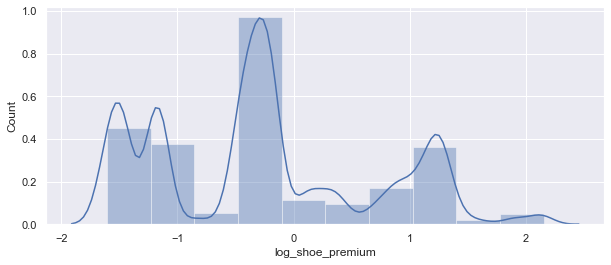

In [531]:

fig = plt.figure(figsize=(10,4))
sns.distplot(stockx_data['log_shoe_premium'] , bins = 10)
plt.ylabel('Count')

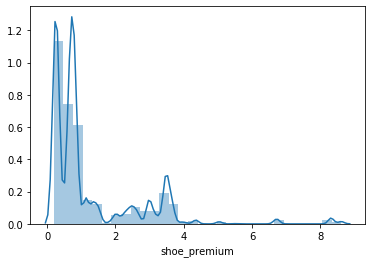

In [117]:
sns.distplot(stockx_data['shoe_premium'] , bins = 30)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


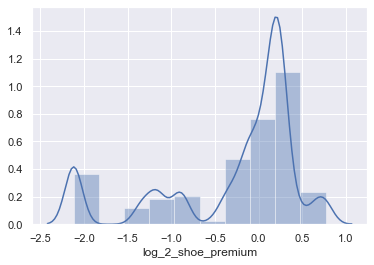

In [529]:
sns.distplot(stockx_data['log_2_shoe_premium'] , bins = 10)

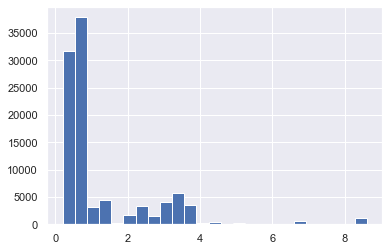

In [511]:
stockx_data['shoe_premium'].hist(bins=25)



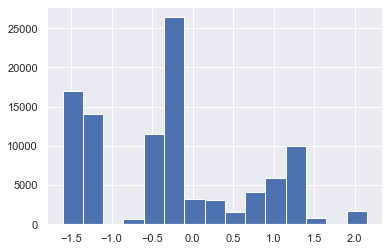

In [516]:
stockx_data['log_shoe_premium'].hist(bins=15)

In [121]:
stockx_data.describe()

,Sale Price,Retail Price,Shoe Size,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up,log_shoe_premium
count,99956.000000,99956.00000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,13293.000000,99956.000000,99956.000000
mean,446.634719,208.61359,9.344181,2018.029013,7.532654,16.150686,2017.467246,8.052243,21.673696,446.634719,1.248245,1284.994508,238.021129,-0.259890
std,255.982969,25.20001,2.329588,0.542357,4.089962,9.085088,0.579352,3.612667,7.805765,232.579595,1.401908,566.357564,266.133179,0.956846
min,186.000000,130.00000,3.500000,2017.000000,1.000000,1.000000,2015.000000,2.000000,1.000000,264.068792,0.200313,773.000000,-34.000000,-1.607876
25%,275.000000,220.00000,8.000000,2018.000000,3.000000,8.000000,2017.000000,6.000000,16.000000,288.708805,0.312313,840.000000,58.000000,-1.163750
50%,370.000000,220.00000,9.500000,2018.000000,8.000000,16.000000,2017.000000,9.000000,25.000000,378.986125,0.722664,899.000000,154.000000,-0.324811
75%,540.000000,220.00000,11.000000,2018.000000,11.000000,24.000000,2018.000000,11.000000,27.000000,512.127083,1.368098,1850.000000,342.000000,0.313421
max,4050.000000,250.00000,17.000000,2019.000000,12.000000,31.000000,2019.000000,12.000000,30.000000,1826.070288,8.610896,2799.000000,3860.000000,2.153028


In [122]:
stockx_data.tail()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up,log_shoe_premium
99951,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,565,220,2018-12-26,8.0,Oregon,2019,2,13,2018,12,26,468.145101,1.127932,NaN,345,0.120386
99952,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,598,220,2018-12-26,8.5,California,2019,2,13,2018,12,26,468.145101,1.127932,NaN,378,0.120386
99953,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,605,220,2018-12-26,5.5,New York,2019,2,13,2018,12,26,468.145101,1.127932,NaN,385,0.120386
99954,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,650,220,2018-12-26,11.0,California,2019,2,13,2018,12,26,468.145101,1.127932,NaN,430,0.120386
99955,2019-02-13,Yeezy,adidas-Yeezy-Boost-350-V2-Static-Reflective,640,220,2018-12-26,11.5,Texas,2019,2,13,2018,12,26,468.145101,1.127932,NaN,420,0.120386


In [427]:
avg_sale_price['Sale Price']

shoe
Adidas-Yeezy-Boost-350-Low-Moonrock                   996.710000
Adidas-Yeezy-Boost-350-Low-Oxford-Tan                1011.514286
Adidas-Yeezy-Boost-350-Low-Pirate-Black-2015          895.094737
Adidas-Yeezy-Boost-350-Low-Pirate-Black-2016          984.237705
Adidas-Yeezy-Boost-350-Low-Turtledove                1531.661765
Adidas-Yeezy-Boost-350-Low-V2-Beluga                  788.704819
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0                 400.439634
Adidas-Yeezy-Boost-350-V2-Blue-Tint                   378.986125
Adidas-Yeezy-Boost-350-V2-Core-Black-Copper           656.631111
Adidas-Yeezy-Boost-350-V2-Core-Black-Green            622.801020
Adidas-Yeezy-Boost-350-V2-Core-Black-Red              937.754967
Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017         804.304438
Adidas-Yeezy-Boost-350-V2-Core-Black-White            718.412238
Adidas-Yeezy-Boost-350-V2-Cream-White                 288.708805
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow          390.586939
Adidas-Yeezy-Boost-3

In [51]:
test_txt = 'Adidas-Yeezy-Boost-350-Low-V2-Beluga'
test_txt.split('-')

['Adidas', 'Yeezy', 'Boost', '350', 'Low', 'V2', 'Beluga']

In [52]:
stockx_data.head()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,788.704819,2.585022,1490.0
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,656.631111,1.984687,1095.0
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,622.801020,1.830914,920.0
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,937.754967,3.262523,1200.0
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,804.304438,2.655929,1160.0


In [53]:
stockx_data['Order year'].unique()

array([2017, 2018, 2019])

In [54]:
stockx_data['Release year'].unique()

array([2016, 2017, 2015, 2018, 2019])

In [55]:
sneakers = stockx_data.groupby('shoe')['Order Date'].count().sort_values(ascending=False)

In [56]:
order_dates = stockx_data.groupby(['Order Date','shoe'])['Sale Price'].sum(ascending=True)

In [57]:
order_dates

Order Date  shoe                                         
2017-09-01  Adidas-Yeezy-Boost-350-Low-V2-Beluga              1097
            Adidas-Yeezy-Boost-350-V2-Core-Black-Copper        685
            Adidas-Yeezy-Boost-350-V2-Core-Black-Green         690
            Adidas-Yeezy-Boost-350-V2-Core-Black-Red          1075
            Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017     1626
                                                             ...  
2019-02-13  Nike-Zoom-Fly-Off-White-Black-Silver              2124
            Nike-Zoom-Fly-Off-White-Pink                      1800
            adidas-Yeezy-Boost-350-V2-Butter                  5153
            adidas-Yeezy-Boost-350-V2-Static                 14615
            adidas-Yeezy-Boost-350-V2-Static-Reflective      10195
Name: Sale Price, Length: 10955, dtype: int64

In [58]:
resell_price_df = stockx_data.groupby('Brand')['Sale Price'].sum().to_frame()

In [59]:
retail_price_df = stockx_data.groupby('Brand')['Retail Price'].sum().to_frame()

In [60]:
resell_price_df.reset_index(inplace=True)

In [61]:
retail_price_df.reset_index(inplace=True)

In [62]:
resell_price_df

,Brand,Sale Price
0,Yeezy,25980669
1,Off-White,18663151


In [63]:
retail_price_df

,Brand,Retail Price
0,Yeezy,15866540
1,Off-White,4985640


## Create the Yeezy Data Frame

In [64]:
yeezy_df = stockx_data[stockx_data['Brand']==' Yeezy']

In [65]:
def strip_brand_yeezy(string):
    """
    Input: shoe string 
    Output: shoe string
    """
    
    string = re.sub('-Yeezy', '',string)
    return string

In [66]:
yeezy_df['shoe'] = yeezy_df['shoe'].apply(strip_brand_yeezy)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
yeezy_df.head(5)

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high
0,2017-09-01,Yeezy,Adidas-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,788.704819,2.585022,1490.0
1,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,656.631111,1.984687,1095.0
2,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,622.801020,1.830914,920.0
3,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,937.754967,3.262523,1200.0
4,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,804.304438,2.655929,1160.0


In [68]:
yeezy_df.describe()

,Sale Price,Retail Price,Shoe Size,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high
count,72162.000000,72162.000000,72162.000000,72162.000000,72162.000000,72162.000000,72162.000000,72162.000000,72162.000000,72162.000000,72162.000000,10731.000000
mean,360.032552,219.873895,9.238332,2018.018722,7.563053,16.192525,2017.311979,8.158213,24.386339,360.032552,0.639533,1192.367999
std,143.732138,1.583109,2.382799,0.561952,4.226785,9.082391,0.544769,3.866060,4.842241,118.545561,0.558575,506.463100
min,186.000000,200.000000,3.500000,2017.000000,1.000000,1.000000,2015.000000,2.000000,11.000000,264.068792,0.200313,773.000000
25%,268.000000,220.000000,8.000000,2018.000000,3.000000,8.000000,2017.000000,4.000000,23.000000,287.066627,0.304848,840.000000
50%,316.000000,220.000000,9.500000,2018.000000,9.000000,16.000000,2017.000000,11.000000,25.000000,361.272206,0.642146,840.000000
75%,399.000000,220.000000,11.000000,2018.000000,11.000000,24.000000,2018.000000,12.000000,29.000000,390.586939,0.775395,1825.000000
max,2300.000000,220.000000,17.000000,2019.000000,12.000000,31.000000,2018.000000,12.000000,30.000000,1531.661765,6.658309,2300.000000


In [69]:
off_white_df = stockx_data[stockx_data['Brand']=='Off-White']

In [70]:
off_white_df.head()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high
128,2017-09-07,Off-White,Nike-Air-Max-90-Off-White,1600,160,2017-09-09,8.0,California,2017,9,7,2017,9,9,709.923445,3.437022,1600.0
129,2017-09-07,Off-White,Nike-Air-Max-90-Off-White,1090,160,2017-09-09,11.5,New York,2017,9,7,2017,9,9,709.923445,3.437022,1600.0
130,2017-09-07,Off-White,Nike-Air-Presto-Off-White,1344,160,2017-09-09,10.0,New York,2017,9,7,2017,9,9,1236.055369,6.725346,1850.0
131,2017-09-07,Off-White,Nike-Air-Presto-Off-White,1325,160,2017-09-09,10.0,Massachusetts,2017,9,7,2017,9,9,1236.055369,6.725346,1850.0
132,2017-09-07,Off-White,Nike-Air-VaporMax-Off-White,1800,250,2017-09-09,12.0,Kentucky,2017,9,7,2017,9,9,856.676190,2.426705,2399.0


In [71]:
off_white_df['shoe'] = off_white_df['shoe'].apply(strip_brand_off)

NameError: name 'strip_brand_off' is not defined

In [72]:
def strip_brand_off(string):
    """
    Input: shoe string 
    Output: shoe string
    """
    
    string = re.sub('-Off-White', '',string)
    return string

In [73]:
strip_brand(test)

NameError: name 'strip_brand' is not defined

In [74]:
test = 'Nike-Air-Masdfsdfadx-90-Off-White'

In [75]:
off_white_df['shoe'].unique()

array(['Nike-Air-Max-90-Off-White', 'Nike-Air-Presto-Off-White',
       'Nike-Air-VaporMax-Off-White',
       'Air-Jordan-1-Retro-High-Off-White-Chicago',
       'Nike-Blazer-Mid-Off-White', 'Nike-Air-Force-1-Low-Off-White',
       'Nike-Air-Max-97-Off-White',
       'Nike-Air-Force-1-Low-Virgil-Abloh-Off-White-AF100',
       'Nike-React-Hyperdunk-2017-Flyknit-Off-White',
       'Nike-Zoom-Fly-Off-White', 'Nike-Air-VaporMax-Off-White-2018',
       'Air-Jordan-1-Retro-High-Off-White-White',
       'Nike-Air-VaporMax-Off-White-Black',
       'Air-Jordan-1-Retro-High-Off-White-University-Blue',
       'Nike-Air-Presto-Off-White-Black-2018',
       'Nike-Air-Presto-Off-White-White-2018',
       'Nike-Zoom-Fly-Mercurial-Off-White-Black',
       'Nike-Zoom-Fly-Mercurial-Off-White-Total-Orange',
       'Nike-Air-Max-97-Off-White-Elemental-Rose-Queen',
       'Nike-Blazer-Mid-Off-White-All-Hallows-Eve',
       'Nike-Blazer-Mid-Off-White-Grim-Reaper',
       'Nike-Blazer-Mid-Off-White-Wolf-Grey

## Computed the mark up of a shoe and placed into it's own column

In [76]:
stockx_data['mark_up'] = stockx_data['Sale Price'] - stockx_data['Retail Price']

In [77]:
stockx_data.describe()

,Sale Price,Retail Price,Shoe Size,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up
count,99956.000000,99956.00000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,13293.000000,99956.000000
mean,446.634719,208.61359,9.344181,2018.029013,7.532654,16.150686,2017.467246,8.052243,21.673696,446.634719,1.248245,1284.994508,238.021129
std,255.982969,25.20001,2.329588,0.542357,4.089962,9.085088,0.579352,3.612667,7.805765,232.579595,1.401908,566.357564,266.133179
min,186.000000,130.00000,3.500000,2017.000000,1.000000,1.000000,2015.000000,2.000000,1.000000,264.068792,0.200313,773.000000,-34.000000
25%,275.000000,220.00000,8.000000,2018.000000,3.000000,8.000000,2017.000000,6.000000,16.000000,288.708805,0.312313,840.000000,58.000000
50%,370.000000,220.00000,9.500000,2018.000000,8.000000,16.000000,2017.000000,9.000000,25.000000,378.986125,0.722664,899.000000,154.000000
75%,540.000000,220.00000,11.000000,2018.000000,11.000000,24.000000,2018.000000,11.000000,27.000000,512.127083,1.368098,1850.000000,342.000000
max,4050.000000,250.00000,17.000000,2019.000000,12.000000,31.000000,2019.000000,12.000000,30.000000,1826.070288,8.610896,2799.000000,3860.000000


In [78]:
stockx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 18 columns):
Order Date            99956 non-null datetime64[ns]
Brand                 99956 non-null object
shoe                  99956 non-null object
Sale Price            99956 non-null int64
Retail Price          99956 non-null int64
Release Date          99956 non-null datetime64[ns]
Shoe Size             99956 non-null float64
Buyer Region          99956 non-null object
Order year            99956 non-null int64
Order month           99956 non-null int64
Order day             99956 non-null int64
Release year          99956 non-null int64
Release month         99956 non-null int64
Release day           99956 non-null int64
average_sale_price    99956 non-null float64
shoe_premium          99956 non-null float64
annual_high           13293 non-null float64
mark_up               99956 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(9), object(3)
memory usage: 13.7+ MB


## Create the dummies for the categorical columns

In [79]:
shoe_dummy = pd.get_dummies(stockx_data['Shoe Size'])

In [80]:
shoe_dummy

,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,...,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0,16.0,17.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
99952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99953,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
release_year_data_dummy = pd.get_dummies(stockx_data['Release year'])

In [82]:
release_year_data_dummy.head()

,2015,2016,2017,2018,2019
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0


In [83]:
brand_dummy = pd.get_dummies(stockx_data['Brand'])

In [84]:
brand_dummy

,Yeezy,Off-White
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
99951,1,0
99952,1,0
99953,1,0
99954,1,0


In [85]:
state_dummy = pd.get_dummies(stockx_data['Buyer Region'])

In [86]:
state_dummy

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99952,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99954,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
order_month_dummy = pd.get_dummies(stockx_data['Order month'])

In [88]:
order_day_dummy = pd.get_dummies(stockx_data['Order day'])

In [89]:
order_year_dummy = pd.get_dummies(stockx_data['Order year'])

In [90]:
release_month_dummy = pd.get_dummies(stockx_data['Release month'])

In [91]:
release_day_dummy = pd.get_dummies(stockx_data['Release day'])

In [92]:
shoe_type_dummy = pd.get_dummies(stockx_data['shoe'])

,Sale Price,Retail Price,average_sale_price,shoe_premium,annual_high,mark_up,3.5,4.0,4.5,5.0,...,Nike-Zoom-Fly-Mercurial-Off-White-Total-Orange,Nike-Zoom-Fly-Off-White,Nike-Zoom-Fly-Off-White-Black-Silver,Nike-Zoom-Fly-Off-White-Pink,adidas-Yeezy-Boost-350-V2-Butter,adidas-Yeezy-Boost-350-V2-Static,adidas-Yeezy-Boost-350-V2-Static-Reflective,2017,2018,2019
0,1097,220,788.704819,2.585022,1490.0,877,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,685,220,656.631111,1.984687,1095.0,465,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,690,220,622.801020,1.830914,920.0,470,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1075,220,937.754967,3.262523,1200.0,855,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,828,220,804.304438,2.655929,1160.0,608,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,565,220,468.145101,1.127932,NaN,345,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99952,598,220,468.145101,1.127932,NaN,378,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99953,605,220,468.145101,1.127932,NaN,385,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99954,650,220,468.145101,1.127932,NaN,430,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [144]:
dummy_df_2 = pd.concat([stockx_data,shoe_dummy,shoe_type_dummy,brand_dummy], axis=1)



SyntaxError: invalid syntax (<ipython-input-144-2afd993e54a0>, line 5)

In [146]:
X = dummy_df_2.drop(columns=['shoe_premium','avg_sale_price'])

y = dummy_df_2['shoe_premium']           

KeyError: "['avg_sale_price'] not found in axis"

In [143]:
import statsmodels.api as sm # import statsmodels 

X = dummy_df_2.drop(columns=['shoe_premium'])
## X usually means our input variables (or independent variables)
y = dummy_df_2["shoe_premium"] ##Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           shoe_premium   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.022e+29
Date:                Tue, 04 Feb 2020   Prob (F-statistic):               0.00
Time:                        09:33:58   Log-Likelihood:             2.8919e+06
No. Observations:               99956   AIC:                        -5.784e+06
Df Residuals:                   99880   BIC:                        -5.783e+06
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                 1.0490   1.37e-15   7.64e+14      0.000       1.049       1.049
Sale Price                                           -0.0045   3.97e-18  -1.13e+15      0.000      -0.004      -0.004
Retail Price                                         -0.0090   7.55e-18  -1.19e+15      0.000      -0.009      -0.009
average_sale_price                                    0.0053   2.64e-18   2.01e+15      0.000       0.005       0.005
mark_up                                               0.0045   3.83e-18   1.17e+15      0.000       0.004       0.004
3.5                                                   0.0403   3.18e-14   1.27e+12      0.000       0.040       0.040
4.0                                                   0.0403   2.29e-15   1.76e+13      0.000       0.040       0.040
4.5                                                   0.0403   2.56e-15   1.58e+13      0.000       0.040       0.040
5.0                                                   0.0403   2.14e-15   1.89e+13      0.000       0.040       0.040
5.5                                                   0.0403   2.23e-15   1.81e+13      0.000       0.040       0.040
6.0                                                   0.0403   2.11e-15   1.92e+13      0.000       0.040       0.040
6.5                                                   0.0403   2.29e-15   1.76e+13      0.000       0.040       0.040
7.0                                                   0.0403   2.12e-15   1.91e+13      0.000       0.040       0.040
7.5                                                   0.0403   2.22e-15   1.81e+13      0.000       0.040       0.040
8.0                                                   0.0403   2.05e-15   1.97e+13      0.000       0.040       0.040
8.5                                                   0.0403   2.05e-15   1.97e+13      0.000       0.040       0.040
9.0                                                   0.0403   1.96e-15   2.06e+13      0.000       0.040       0.040
9.5                                                   0.0403   1.97e-15   2.04e+13      0.000       0.040       0.040
10.0                                                  0.0403   1.95e-15   2.07e+13      0.000       0.040       0.040
10.5                                                  0.0403   1.97e-15   2.05e+13      0.000       0.040       0.040
11.0                                                  0.0403   1.97e-15   2.05e+13      0.000       0.040       0.040
11.5                                                  0.0403   2.08e-15   1.94e+13      0.000       0.040       0.040
12.0                                                  0.0403      2e-15   2.02e+13      0.000       0.040       0.040
12.5           

In [139]:
dummy_df_2.drop(columns=['Brand','Shoe Size','Buyer Region','Release Date','shoe','Release year','Release month','Release day','Order year','Order month','Order day'],inplace=True)

In [141]:
dummy_df_2.drop(columns=['Order Date','annual_high','log_shoe_premium'],inplace=True)



In [142]:
dummy_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 83 columns):
Sale Price                                           99956 non-null int64
Retail Price                                         99956 non-null int64
average_sale_price                                   99956 non-null float64
shoe_premium                                         99956 non-null float64
mark_up                                              99956 non-null int64
3.5                                                  99956 non-null uint8
4.0                                                  99956 non-null uint8
4.5                                                  99956 non-null uint8
5.0                                                  99956 non-null uint8
5.5                                                  99956 non-null uint8
6.0                                                  99956 non-null uint8
6.5                                                  99956 non-null uint8

In [94]:
stockx_data.head()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,788.704819,2.585022,1490.0,877
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,656.631111,1.984687,1095.0,465
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,622.801020,1.830914,920.0,470
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,937.754967,3.262523,1200.0,855
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,804.304438,2.655929,1160.0,608


In [95]:
dummy_df.drop(columns=['Brand','Shoe Size','Buyer Region','Release Date','shoe','Release year','Release month','Release day','Order year','Order month','Order day'],inplace=True)





In [96]:
dummy_df.drop(columns=['Order Date'],inplace=True)

In [97]:
target = dummy_df['Sale Price'] 

In [98]:
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()
# summary = model.summary()


X = dummy_df.copy()
y = X.pop('Sale Price')

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
summary = model.summary()

    
# summary_model(X, y)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


MissingDataError: exog contains inf or nans

In [99]:
summary

NameError: name 'summary' is not defined

In [100]:
dummy_df

,Sale Price,Retail Price,average_sale_price,shoe_premium,annual_high,mark_up,3.5,4.0,4.5,5.0,...,Nike-Zoom-Fly-Mercurial-Off-White-Total-Orange,Nike-Zoom-Fly-Off-White,Nike-Zoom-Fly-Off-White-Black-Silver,Nike-Zoom-Fly-Off-White-Pink,adidas-Yeezy-Boost-350-V2-Butter,adidas-Yeezy-Boost-350-V2-Static,adidas-Yeezy-Boost-350-V2-Static-Reflective,2017,2018,2019
0,1097,220,788.704819,2.585022,1490.0,877,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,685,220,656.631111,1.984687,1095.0,465,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,690,220,622.801020,1.830914,920.0,470,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1075,220,937.754967,3.262523,1200.0,855,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,828,220,804.304438,2.655929,1160.0,608,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,565,220,468.145101,1.127932,NaN,345,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99952,598,220,468.145101,1.127932,NaN,378,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99953,605,220,468.145101,1.127932,NaN,385,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
99954,650,220,468.145101,1.127932,NaN,430,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [101]:
yeezy_shoe_size = pd.get_dummies(yeezy_df['Shoe Size'])
yeezy_dummy_df = pd.concat([yeezy_df['Sale Price'],yeezy_shoe_size], axis=1)



In [102]:
yeezy_dummy_df

,Sale Price,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,...,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,16.0,17.0
0,1097,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,685,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,690,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1075,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,828,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,565,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99952,598,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99953,605,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99954,650,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [103]:
yeezy_dummy_df.columns

Index(['Sale Price',          3.5,          4.0,          4.5,          5.0,
                5.5,          6.0,          6.5,          7.0,          7.5,
                8.0,          8.5,          9.0,          9.5,         10.0,
               10.5,         11.0,         11.5,         12.0,         12.5,
               13.0,         13.5,         14.0,         14.5,         16.0,
               17.0],
      dtype='object')

In [104]:
yeezy_dummy_df[3.5]

0        0
1        0
2        0
3        0
4        0
        ..
99951    0
99952    0
99953    0
99954    0
99955    0
Name: 3.5, Length: 72162, dtype: uint8

In [416]:
import statsmodels.api as sm # import statsmodels 

X = stock[[' Yeezy','Off-White','']]
## X usually means our input variables (or independent variables)
y = dummy_df["Sale Price"] ##Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale Price   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                 4.226e+04
Date:                Mon, 03 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:19:34   Log-Likelihood:            -6.7847e+05
No. Observations:               99956   AIC:                         1.357e+06
Df Residuals:                   99954   BIC:                         1.357e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        343.8379      0.505    680.864      0.000     342.848     344.828
 Yeezy        16.1946      0.684     23.679      0.000      14.854      17.535
Off-White    327.6433      0.899    364.641      0.000     325.882     329.404
==============================================================================
Omnibus:                    71190.817   Durbin-Watson:                   0.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1824254.659
Skew:                           3.137   Prob(JB):                         0.00
Kurtosis:                      22.966   Cond. No.                     3.71e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.18e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [105]:
yeezy_df

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high
0,2017-09-01,Yeezy,Adidas-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,788.704819,2.585022,1490.0
1,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,656.631111,1.984687,1095.0
2,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,622.801020,1.830914,920.0
3,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,937.754967,3.262523,1200.0
4,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,804.304438,2.655929,1160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,2019-02-13,Yeezy,adidas-Boost-350-V2-Static-Reflective,565,220,2018-12-26,8.0,Oregon,2019,2,13,2018,12,26,468.145101,1.127932,NaN
99952,2019-02-13,Yeezy,adidas-Boost-350-V2-Static-Reflective,598,220,2018-12-26,8.5,California,2019,2,13,2018,12,26,468.145101,1.127932,NaN
99953,2019-02-13,Yeezy,adidas-Boost-350-V2-Static-Reflective,605,220,2018-12-26,5.5,New York,2019,2,13,2018,12,26,468.145101,1.127932,NaN
99954,2019-02-13,Yeezy,adidas-Boost-350-V2-Static-Reflective,650,220,2018-12-26,11.0,California,2019,2,13,2018,12,26,468.145101,1.127932,NaN


In [106]:
yeezy_df.head()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high
0,2017-09-01,Yeezy,Adidas-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,788.704819,2.585022,1490.0
1,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,656.631111,1.984687,1095.0
2,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,622.801020,1.830914,920.0
3,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,937.754967,3.262523,1200.0
4,2017-09-01,Yeezy,Adidas-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,804.304438,2.655929,1160.0


In [107]:
x = stockx_data['']

KeyError: ''

In [158]:
stockx_2017 = stockx_data[stockx_data['Order year'] == 2017]
stockx_2018 = stockx_data[stockx_data['Order year'] == 2018]
stockx_2019 = stockx_data[stockx_data['Order year'] == 2019]

In [159]:
stockx_2017.describe()

,Sale Price,Retail Price,Shoe Size,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up,log_shoe_premium
count,13293.000000,13293.000000,13293.000000,13293.0,13293.000000,13293.000000,13293.000000,13293.000000,13293.000000,13293.000000,13293.000000,13293.000000,13293.000000,13293.000000
mean,515.276010,211.943880,9.591213,2017.0,11.401565,18.157752,2016.958098,9.913714,19.106071,507.389505,1.508651,1284.994508,303.332130,0.068007
std,242.281977,21.466982,2.211603,0.0,0.804201,8.648493,0.217650,2.840981,7.776232,281.090170,1.681605,566.357564,249.559483,0.726966
min,290.000000,130.000000,4.000000,2017.0,9.000000,1.000000,2015.000000,2.000000,1.000000,288.708805,0.312313,773.000000,70.000000,-1.163750
25%,371.000000,220.000000,8.500000,2017.0,11.000000,12.000000,2017.000000,9.000000,16.000000,378.986125,0.722664,840.000000,152.000000,-0.324811
50%,408.000000,220.000000,10.000000,2017.0,12.000000,19.000000,2017.000000,11.000000,25.000000,400.439634,0.820180,899.000000,192.000000,-0.198231
75%,575.000000,220.000000,11.000000,2017.0,12.000000,26.000000,2017.000000,11.000000,25.000000,400.439634,0.820180,1850.000000,385.000000,-0.198231
max,2799.000000,250.000000,17.000000,2017.0,12.000000,31.000000,2017.000000,12.000000,29.000000,1769.800000,8.314737,2799.000000,2609.000000,2.118029


In [160]:
stockx_2018.describe()

,Sale Price,Retail Price,Shoe Size,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up,log_shoe_premium
count,70470.000000,70470.000000,70470.000000,70470.0,70470.000000,70470.000000,70470.000000,70470.000000,70470.000000,70470.000000,70470.000000,0.0,70470.000000,70470.000000
mean,445.914417,208.377466,9.360863,2018.0,8.228097,16.783298,2017.485923,7.455002,22.049709,444.119473,1.243878,NaN,237.536952,-0.304253
std,266.044920,25.868907,2.325797,0.0,3.377399,9.071835,0.556753,3.511176,7.853122,234.095803,1.412106,NaN,276.942943,0.999084
min,186.000000,130.000000,3.500000,2018.0,1.000000,1.000000,2015.000000,2.000000,1.000000,264.068792,0.200313,NaN,-34.000000,-1.607876
25%,271.000000,200.000000,8.000000,2018.0,6.000000,9.000000,2017.000000,4.000000,16.000000,287.066627,0.312313,NaN,53.000000,-1.163750
50%,355.000000,220.000000,9.500000,2018.0,9.000000,17.000000,2018.000000,6.000000,25.000000,361.272206,0.722664,NaN,140.000000,-0.324811
75%,555.000000,220.000000,11.000000,2018.0,11.000000,25.000000,2018.000000,11.000000,29.000000,528.822604,1.513913,NaN,350.000000,0.414698
max,4050.000000,250.000000,17.000000,2018.0,12.000000,31.000000,2019.000000,12.000000,30.000000,1826.070288,8.610896,NaN,3860.000000,2.153028


In [161]:
stockx_2019.describe()

,Sale Price,Retail Price,Shoe Size,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up,log_shoe_premium
count,16193.000000,16193.000000,16193.000000,16193.0,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,16193.000000,0.0,16193.000000,16193.000000
mean,393.421046,206.907306,9.068795,2019.0,1.330143,11.750015,2017.803928,9.123263,22.145124,407.706544,1.053480,NaN,186.513741,-0.336002
std,203.905319,24.843529,2.411871,0.0,0.470279,8.095435,0.596974,3.839736,7.199861,161.219388,1.019327,NaN,214.817887,0.878205
min,190.000000,130.000000,3.500000,2019.0,1.000000,1.000000,2015.000000,2.000000,1.000000,264.068792,0.200313,NaN,-30.000000,-1.607876
25%,269.000000,220.000000,7.500000,2019.0,1.000000,6.000000,2017.000000,6.000000,18.000000,287.066627,0.304848,NaN,50.000000,-1.187941
50%,326.000000,220.000000,9.500000,2019.0,1.000000,9.000000,2018.000000,11.000000,26.000000,390.586939,0.775395,NaN,111.000000,-0.254382
75%,475.000000,220.000000,10.500000,2019.0,2.000000,17.000000,2018.000000,12.000000,27.000000,468.145101,1.127932,NaN,266.000000,0.120386
max,3400.000000,250.000000,17.000000,2019.0,2.000000,31.000000,2019.000000,12.000000,30.000000,1826.070288,8.610896,NaN,3210.000000,2.153028


In [178]:
stockx_2017['Order month'].unique()

array([ 9, 10, 11, 12])

In [236]:
stockx_2017

,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up,log_shoe_premium
Order Date,,,,,,,,,,,,,,,,,,
2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,788.704819,2.585022,1490.0,877,0.949734
2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,656.631111,1.984687,1095.0,465,0.685461
2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,622.801020,1.830914,920.0,470,0.604815
2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,937.754967,3.262523,1200.0,855,1.182501
2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,804.304438,2.655929,1160.0,608,0.976795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,Off-White,Nike-Air-VaporMax-Off-White,650,250,2017-09-09,7.5,New York,2017,12,31,2017,9,9,856.676190,2.426705,2399.0,400,0.886534
2017-12-31,Off-White,Nike-Blazer-Mid-Off-White,600,130,2017-09-09,11.5,Virginia,2017,12,31,2017,9,9,695.475050,4.349808,1020.0,470,1.470132
2017-12-31,Off-White,Nike-Blazer-Mid-Off-White,586,130,2017-09-09,10.0,Wisconsin,2017,12,31,2017,9,9,695.475050,4.349808,1020.0,456,1.470132


In [182]:
stockx_2017.head()

,Order Date,Brand,shoe,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up,log_shoe_premium
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,2017,9,1,2016,9,24,788.704819,2.585022,1490.0,877,0.949734
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,656.631111,1.984687,1095.0,465,0.685461
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,2017,9,1,2016,11,23,622.801020,1.830914,920.0,470,0.604815
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,2017,9,1,2016,11,23,937.754967,3.262523,1200.0,855,1.182501
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,2017,9,1,2017,2,11,804.304438,2.655929,1160.0,608,0.976795


In [195]:
stockx_2017.groupby(['Order Date']).mean()

,Sale Price,Retail Price,Shoe Size,Order year,Order month,Order day,Release year,Release month,Release day,average_sale_price,shoe_premium,annual_high,mark_up,log_shoe_premium
Order Date,,,,,,,,,,,,,,
2017-09-01,653.000000,220.000000,10.369565,2017.0,9.0,1.0,2016.782609,4.434783,24.173913,464.255996,1.110255,941.434783,433.000000,-0.226869
2017-09-02,649.600000,220.000000,9.833333,2017.0,9.0,2.0,2016.800000,4.133333,23.200000,496.567517,1.257125,974.800000,429.600000,-0.112547
2017-09-03,672.437500,220.000000,9.812500,2017.0,9.0,3.0,2016.750000,4.875000,23.312500,501.362387,1.278920,960.625000,452.437500,-0.144501
2017-09-04,623.764706,220.000000,9.852941,2017.0,9.0,4.0,2016.823529,4.176471,24.352941,433.150318,0.968865,923.941176,403.764706,-0.341184
2017-09-05,648.772727,220.000000,10.409091,2017.0,9.0,5.0,2016.772727,4.681818,24.045455,469.984706,1.136294,941.272727,428.772727,-0.240131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,432.029661,216.398305,9.402542,2017.0,12.0,27.0,2016.983051,11.055085,17.682203,438.076068,1.076140,1637.504237,215.631356,-0.140505
2017-12-28,415.078189,216.255144,9.489712,2017.0,12.0,28.0,2016.979424,11.172840,17.477366,434.179877,1.065609,1656.086420,198.823045,-0.142693
2017-12-29,431.040359,216.771300,9.542601,2017.0,12.0,29.0,2016.973094,10.995516,17.654709,442.176906,1.091058,1629.430493,214.269058,-0.135487


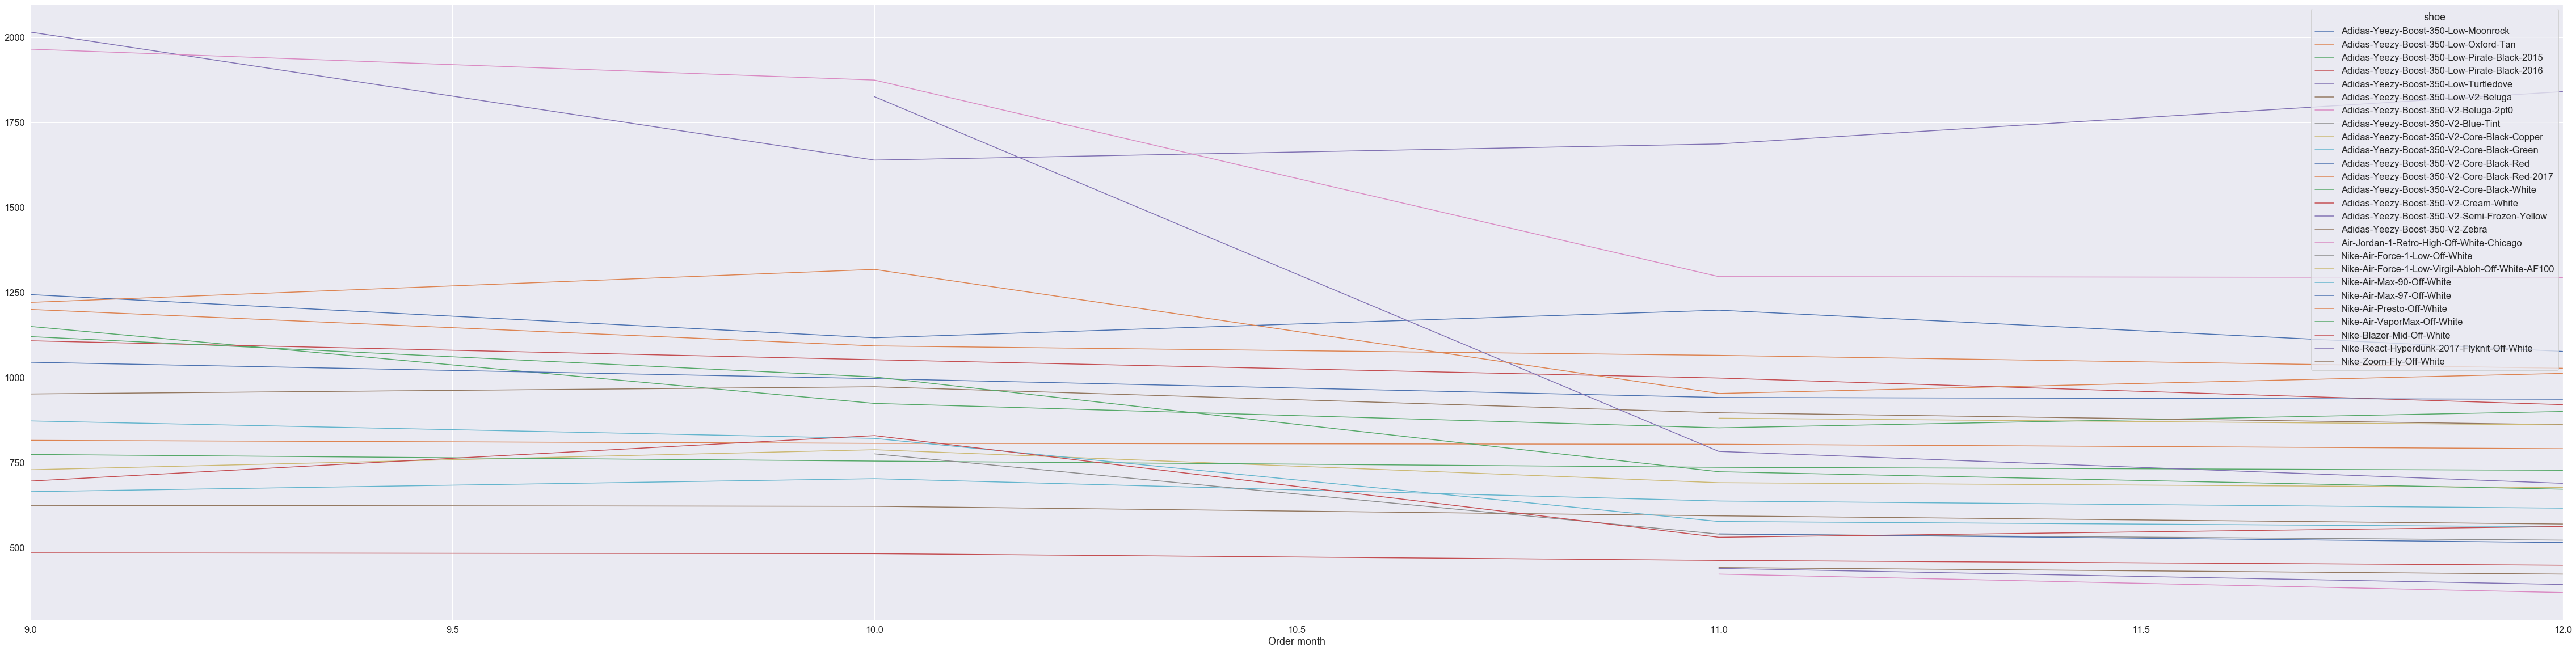

In [239]:
# plot data
fig, ax = plt.subplots(figsize=(80,20))
# use unstack()
stockx_2017.groupby(['Order month','shoe']).mean()['Sale Price'].unstack().plot(ax=ax)

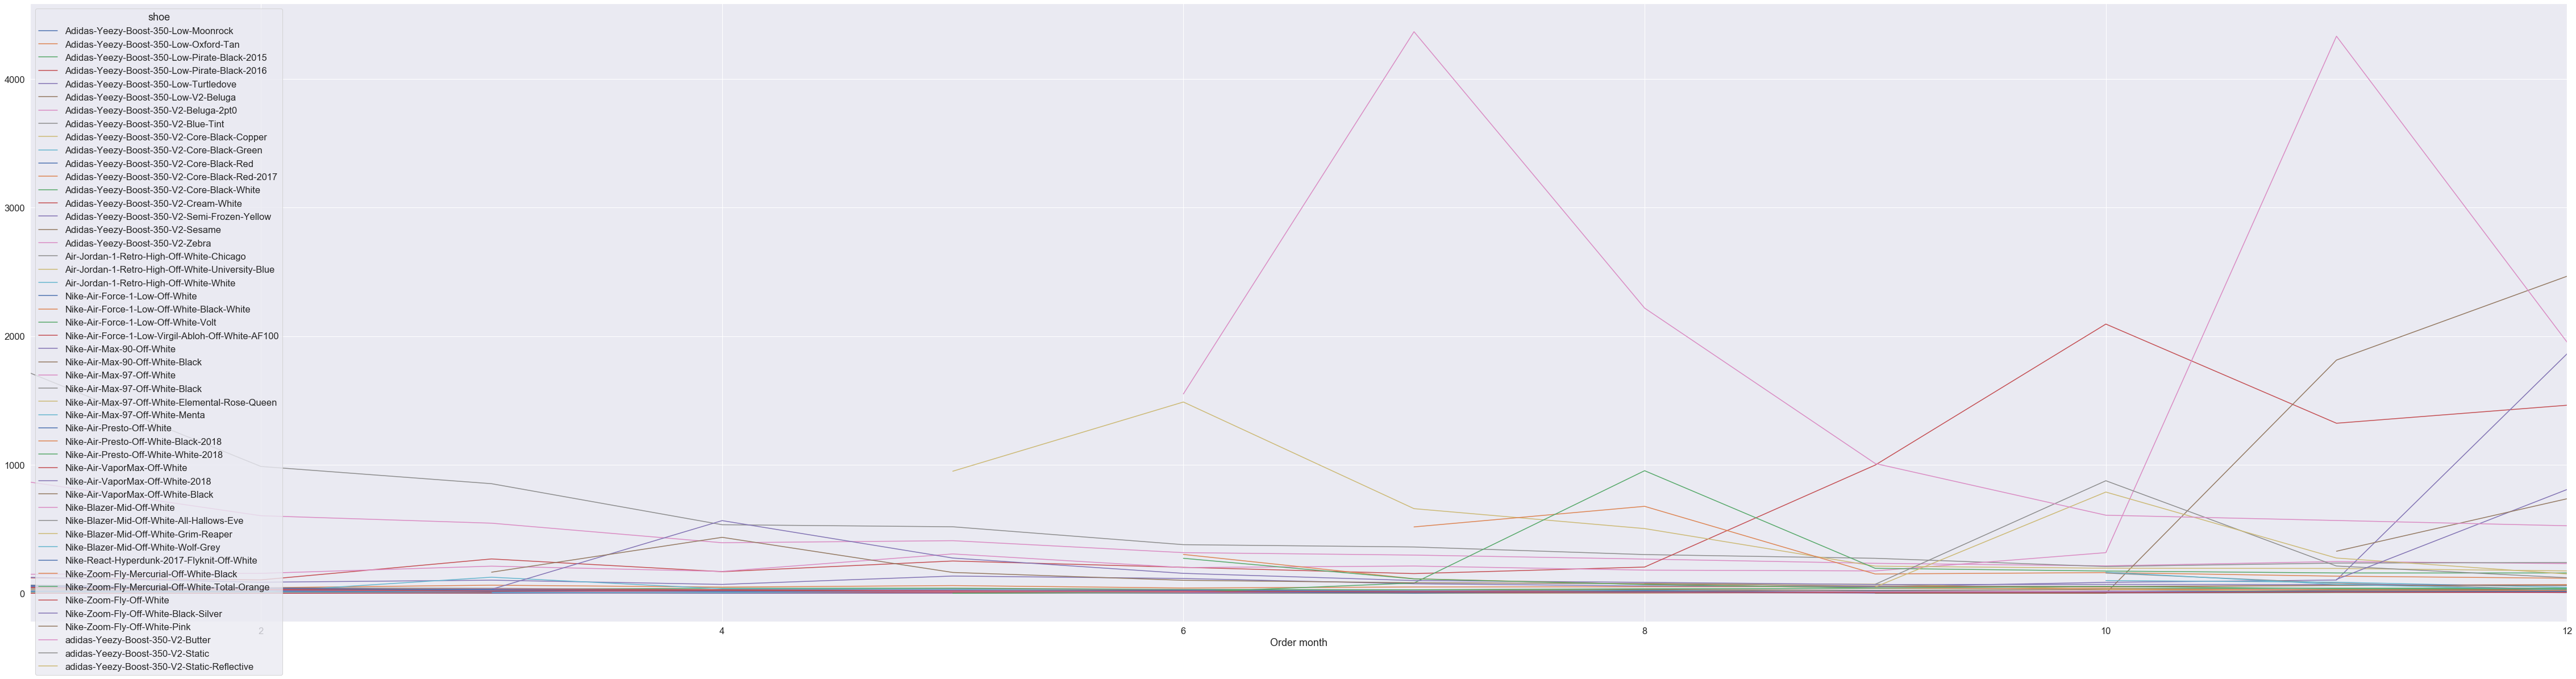

In [248]:
# plot data
fig, ax = plt.subplots(figsize=(80,20))
# use unstack()
stockx_2018.groupby(['Order month','shoe']).count()['Order Date'].unstack().plot(ax=ax)

In [276]:
top_shoes_sold_average_2017 = stockx_2017.groupby('shoe')['average_sale_price'].max().sort_values(ascending=False)

In [281]:
top_shoes_sold_average_2017_df = top_shoes_sold_average_2017.to_frame().reset_index()

In [291]:
top_shoes_sold_average_2017_df.iloc[0:5]

,shoe,average_sale_price
0,Air-Jordan-1-Retro-High-Off-White-Chicago,1769.800000
1,Adidas-Yeezy-Boost-350-Low-Turtledove,1531.661765
2,Nike-Air-Presto-Off-White,1236.055369
3,Adidas-Yeezy-Boost-350-Low-Oxford-Tan,1011.514286
4,Adidas-Yeezy-Boost-350-Low-Moonrock,996.710000


In [294]:
top_2017_arr = []

for i in top_shoes_sold_average_2017_df.iloc[0:5]['shoe']:
    top_2017_arr.append(i)

In [295]:
top_2017_arr

['Air-Jordan-1-Retro-High-Off-White-Chicago',
 'Adidas-Yeezy-Boost-350-Low-Turtledove',
 'Nike-Air-Presto-Off-White',
 'Adidas-Yeezy-Boost-350-Low-Oxford-Tan',
 'Adidas-Yeezy-Boost-350-Low-Moonrock']

In [274]:
top_shoes_sold_average_2017

In [203]:
stockx_2017 = stockx_2017.set_index('Order Date')

In [227]:
shoes_arr = stockx_2017['shoe'].unique()

In [219]:
x = stockx_2017[stockx_2017['shoe'] == 'Adidas-Yeezy-Boost-350-Low-V2-Beluga']

In [307]:
shoe_2017_1 = stockx_2017[stockx_2017['shoe'] == 'Air-Jordan-1-Retro-High-Off-White-Chicago']
shoe_2017_2 = stockx_2017[stockx_2017['shoe'] == 'Adidas-Yeezy-Boost-350-Low-Turtledove']
shoe_2017_3 = stockx_2017[stockx_2017['shoe'] == 'Nike-Air-Presto-Off-White']
shoe_2017_4 = stockx_2017[stockx_2017['shoe'] == 'Adidas-Yeezy-Boost-350-Low-Oxford-Tan']
shoe_2017_5 = stockx_2017[stockx_2017['shoe'] == 'Adidas-Yeezy-Boost-350-Low-Moonrock']

In [245]:
stockx_2017['shoe'].max()

'Nike-Zoom-Fly-Off-White'

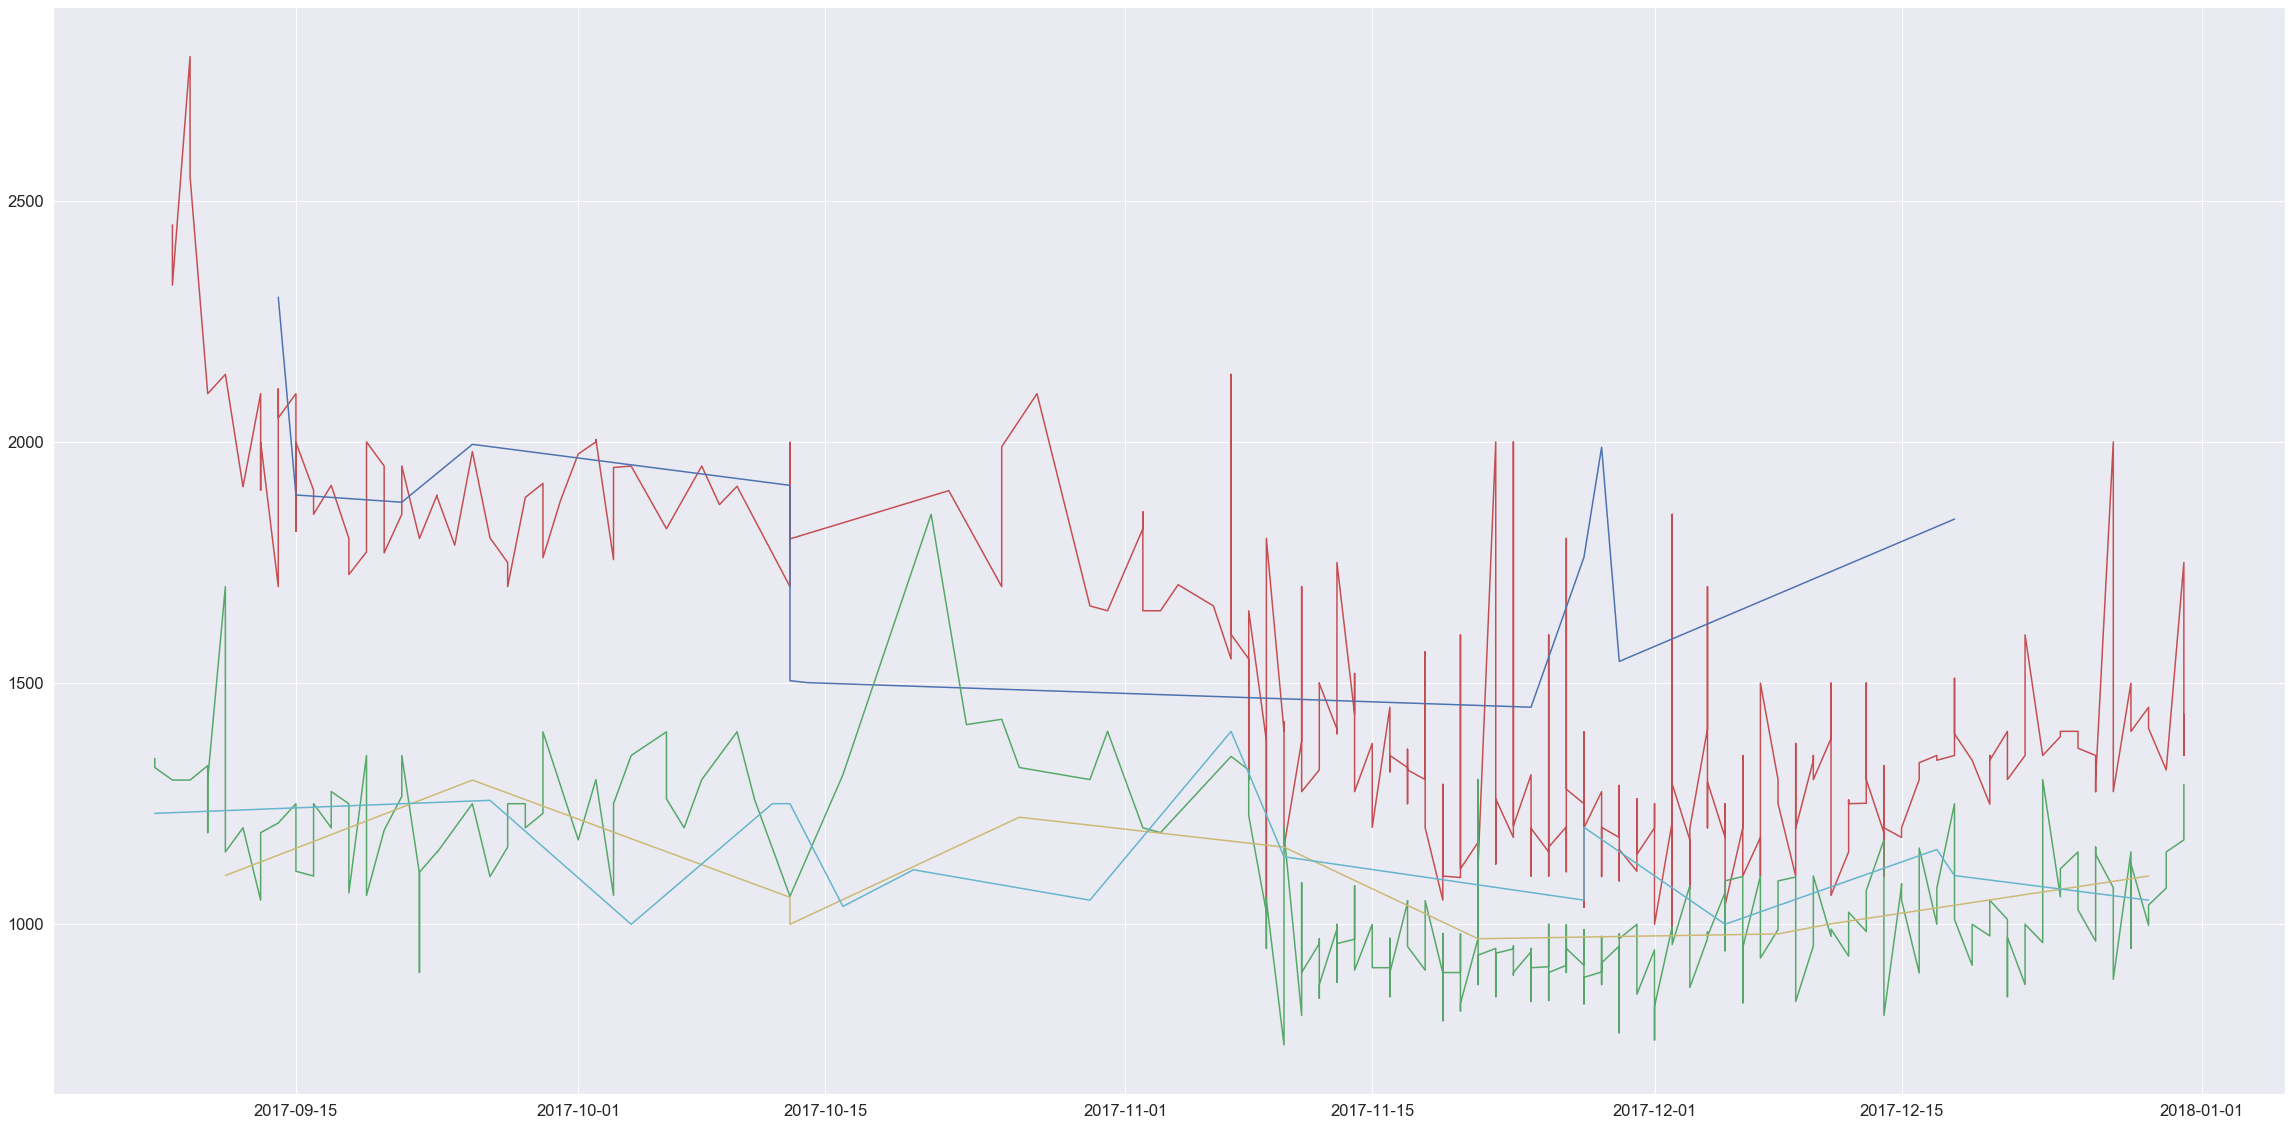

In [310]:
fig, ax = plt.subplots(figsize=(40,20))

a = shoe_2017_1['Sale Price']
b = shoe_2017_2['Sale Price']
c = shoe_2017_3['Sale Price']
d = shoe_2017_4['Sale Price']
e = shoe_2017_5['Sale Price']

plt.plot(a,'r')
plt.plot(b,'b')
plt.plot(c,'g')
plt.plot(d,'y')
plt.plot(e,'c')